
# Chapter 3

# Lab: Linear Regression

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm

In [3]:
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

> _Note_: **Variance Inflation Factor (VIF)** is a way to estimate the ratio of the variance of $b_j$ when fitted with all other predictors, and the variance when fitted alone. It allows us to estimate how much the variance of a predicor increases due to collinearity with other predictors. If the VIF is high (>10), multicollinearity is high, with a common threshold on 5.

> But where is that used?

We will also use some functions written for the labs in this book in the `ISLP`
package.

In [4]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

### Inspecting Objects and Namespaces
The
function  `dir()`
provides a list of
objects in a namespace.

In [5]:
dir();

 This shows you everything that `Python` can find at the top level.
There are certain objects like `__builtins__` that contain references to built-in
functions like `print()`.

Every python object has its own notion of
namespace, also accessible with `dir()`. This will include
both the attributes of the object
as well as any methods associated with it. For instance, we see `'sum'` in the listing for an
array.

In [6]:
A = np.array([3,5,11])
dir(A);

## Simple Linear Regression

## Main hypothesis

1. **Additivity**: The relationship between each predictor and `y` does **not** depend on the value of other predictors.
   - If this where not true, we would have to consider **synergy** between predictors, where $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon$.
         - This can be detected by reviewing the **correlation matrix** of the predictors, but multi-colinearity is hard to determine by looking at that matrix only. Therefore, VIF (Variance Inflation Factor), defined as the ratio between the variance of $\beta_j$ if we use all predictors on the fitting, and the variance of $\beta_j$ when its the only predictor used on the fitting. 5 or 10 show colinearity between predictors.
         $$
             VIF(\beta) = \frac{1}{1-R_{x_j|_{x-j}}}
         $$
         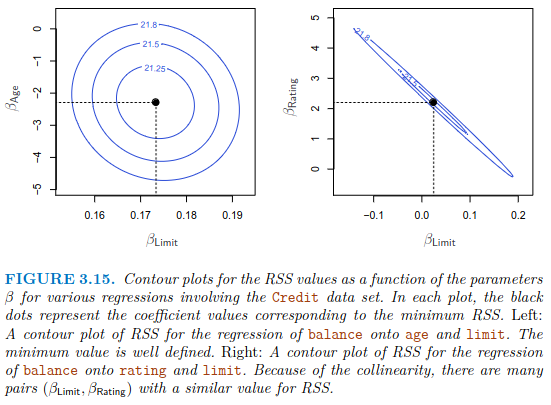
   - When **error terms $\epsilon_i$ are somehow correlated**, calculated p-values are below reality. _Tracking_ on the residual plots is a way of detecting this, as adjacent residues end up having similar residual values.
         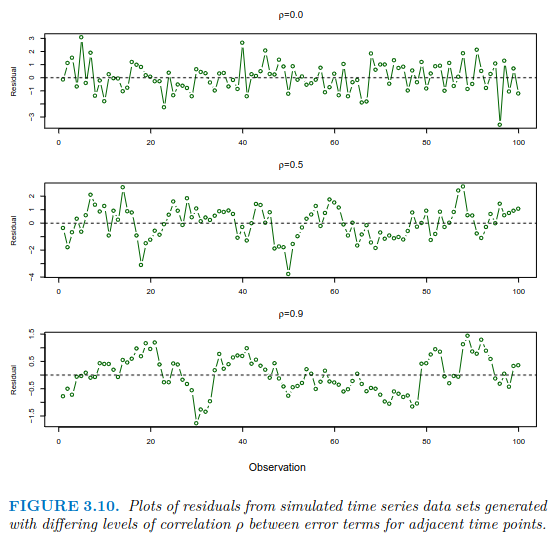
         
3. **Linearity**: The relationship between each predictor and `y` does **not** depend on the value of the predictor.
       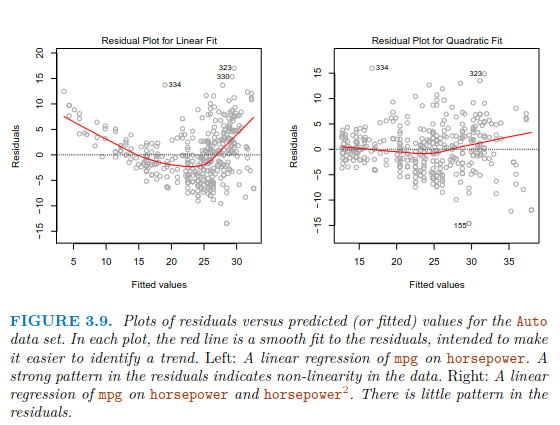
   - If a relationship like that existed, we could propose a **Polynomial Regression** like $y = \beta_0 + \beta_1 x + \beta_2 x^2 + ...$. This is easy to solve if we decide to apply substitution.
   - When the **variance $\sigma_i^2$ is not constant** (when, for example, we can detect a funnel shape on the residual plots), a transformation may be required (e.g. $y \rightarrow log(y)$ or $y \rightarrow \sqrt(y)$) or a weighted least squares may be due.
     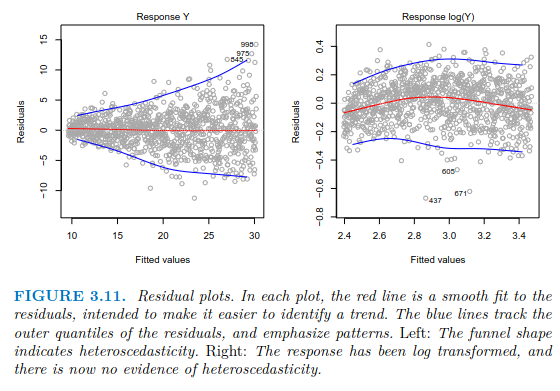

### Using ISLP + statmodels
In this section we will  construct model 
matrices (also called design matrices) using the `ModelSpec()`  transform from `ISLP.models`.

We  will use the `Boston` housing data set, which is contained in the `ISLP` package.  The `Boston` dataset records  `medv`  (median house value) for $506$ neighborhoods
around Boston.  We will build a regression model to predict  `medv`  using $13$
predictors such as  `rmvar`  (average number of rooms per house),
 `age`  (proportion of owner-occupied units built prior to 1940), and  `lstat`  (percent of
households with low socioeconomic status).  We will use `statsmodels` for this
task, a `Python` package that implements several commonly used
regression methods.

We have included a simple loading function `load_data()` in the
`ISLP` package:

In [7]:
Boston = load_data("Boston")
print(Boston.columns)
Boston

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


Type `Boston?` to find out more about these data.

We start by using the `sm.OLS()`  function to fit a
simple linear regression model.  Our response will be
 `medv`  and  `lstat`  will be the single predictor.
For this model, we can create the model matrix by hand.

OLS: Ordinary Least Squares

In [8]:
print('Shape: \n -->', Boston.shape)
print('Columns: \n -->', Boston.columns)

Shape: 
 --> (506, 13)
Columns: 
 --> Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')


In [9]:
Boston.lstat #one of the columns

0      4.98
1      9.14
2      4.03
3      2.94
4      5.33
       ... 
501    9.67
502    9.08
503    5.64
504    6.48
505    7.88
Name: lstat, Length: 506, dtype: float64

In [10]:
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]), # A vector of 506 ones.
                  'lstat': Boston['lstat']})
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [11]:
# Another way of doing the intercept column addition is by using add_constant()
X_with_add_constant = sm.add_constant(Boston['lstat'])
X_with_add_constant

,const,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


We extract the response, and fit the model.

**Simple linear regression**: 
$$
y = \beta_0+\beta_1 X + \epsilon, \epsilon=\text{intrinsic error}
$$

$$
\begin{eqnarray}
\text{intercept} = \hat{\beta_0} &= \bar{y}-\beta_1 \bar{X} + \epsilon \\
\text{coef} = \hat{\beta_1} &= \frac{\sum_{i=1}^{n} (x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{}{(x_i-\bar{x})^2}}
\end{eqnarray}
$$

It's an unbiased predictor.

Los errores estándar de todos los estimadores ($\beta_0$, $\beta_1$, $\mu$) dependen del error intrínseco y de la cantidad de muestras. Como el error intrínseco es desconocido, se tiene que estimar el residual standard error.

**El RSE para el caso de una regresión lineal es una forma de indicar qué tanto de la variabilidad de la muestra ha sido capaz de ser explicada por la regresión lineal: Si el error es bajo, la muestra tiene pinta de lineal: Que en promedio las muestras no se desvían demasiado de la línea de regresión encontrada**.

$$
\begin{eqnarray}
SE{\beta_0}, SE{\beta_1}, SE{\mu} \approx f(\sigma(\epsilon), n), \epsilon \text{ desconocido}\\
\hat{\sigma(\epsilon)} = \text{Residual Standard Error}, RSE &=  \sqrt{RSS/(n-2)} =\sqrt{RSS/(n-p-1)}, \\
RSS &= \sum_{i=1}^n (y_i-\hat{y_i}^2)
\end{eqnarray}
$$


```mermaid
flowchart LR
    samples --> id1[b1, b2, mu] --> id2["SE(b1), SE(b2), SE(mu)
    Standard Errors?"] --> SEEpsilon["SE[epsilon]?
    intrinsic error"] --estimate--> RSS["RSS
    Residual Sum
    of Squares"] --> RSE["RSE
    Residual Standard
    Error"] --> confid["Confidence Intervals"] --> hyp["Hypothesis tests:
    H0: no link between x and y"]
    t["t-statistics
    t of n-2 dof"] ----> p["p-value
    prob of rejecting H0 with
    the samples when H0 is true"] --> hyp
```

```mermaid
flowchart LR
    p["low p-value"] --> prob["low probability of rejecting H0 if it's true"] --> rel["There is a relationship between X and y"] --> rej["We reject H0 with certain confidence"]
```

**How does Linear Regression compare to KNN?**
- KNN is more flexible, non-parametric
- KNN is harder to interpret
- KNN works better with few predictors ($p$).

In [13]:
y = Boston['medv'] # y, the response, is one of the columns of the Dataframe.
# X has to be contructed by an intercept column + the column corresponding to the predictor to be used.

# Defines model and fits it with the data we provide for.
model = sm.OLS(y, X) # This will use Ordinary Least Squares model from statmodels
results = model.fit()

# Print the obtained parameters
print('--> params: \n', results.params)
print('---')
print('--> tvalues: \n', results.tvalues)

--> params: 
 intercept    34.553841
lstat        -0.950049
dtype: float64
---
--> tvalues: 
 intercept    61.415146
lstat       -24.527900
dtype: float64


In [14]:
results.summary()  # could also use summary2()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           5.08e-88
Time:                        20:59:55   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- **RSE: Residual Standard Error**: Promedio en que las muestras se desvían de la línea de regresión calculada. Estima $\sigma(\epsilon)$. Should be low.

- **Adjusted R-squared** is close to 0.5, as is R-squared. Probably the correlation is not that good. $R^2 = \frac{TSS-RSS}{TSS}$, where $TSS$ is the total sum of squares, while $RSS$ is the Residual Sum of Squares. Therefore, the R-Squared parameter indicates the proportion of the variance that is not explained by the linear regression.

  - If close to 1, there is probably a linear regression between X and Y.
  - For simple regression, $R^2 = Corr(X,y)^2$
  - For multiple regression, $R^2 = Corr(y, \hat{y})$

The only difference between $R^2$ and Adjusted $R^2$ is the fact that the latter corrects for the case in which many predictors are involved.
$$
\text{Adjusted } R^2 =\left( \frac{TSS/(n-1)-RSS/(n - p - 1)}{TSS / (n - 1)} \right)
$$

```mermaid
flowchart LR
    reg["b0, b1"] --> RSS --> RSE --> bl["Better low"]
    reg --> TSS
    RSS & TSS --> R2 --> b1["Better close to 1"]
    RSS & TSS --> Adj-R2 --> b1
    RSS & TSS --> F
    F["F_statistics"] --> bh["Better higher than 1"]
    BIC --> bl
    AIC --> bl
    style Adj-R2 fill:#f9f,stroke:#333,stroke-width:4px
    style F fill:#f9f,stroke:#333,stroke-width:4px
    style bl fill:#c11,stroke:#333,stroke-width:1px
    style b1 fill:#c11,stroke:#333,stroke-width:1px
    style bh fill:#c11,stroke:#333,stroke-width:1px
    style reg fill:#a17,stroke:#333,stroke-width:1px
```
     
- **[AIC (Akaike information Criterion)](https://en.wikipedia.org/wiki/Akaike_information_criterion)** is a way to compare different models for model selection. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. The model is better if the AIC value is lower.
- **[Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion)** or Schwarz information criterion (also SIC, SBC, SBIC): The lower the better. $BIC=k \ln(n) - 2\ln(\hat{L})$

- **Log-Likelihood**: $\sum_{i=1}^{n} ln[f_x(x_i)]$, logarithm of likelihood, assuming independence. The basic AIC formula $AIC = -2(log-likelihood) + 2K = (-2)*(-1641.5)+2*1 = 3285$.
- **F-statistics**: It comes from dividing two variances. Higher than 1 means we reject H0, meaning we should accept that $\beta_1$ is not 0. It works only if we have more samples than predictors ($p<n$).
$$ 
F_{statistic} = \frac{(TSS-RSS)/p}{RSS/(n-p-1)}
$$

- We see that $\beta_0$ is 34.55, $\beta_1$ is -0.95 in our case (downward slope!). With $\beta_1$ being the relationship between x and y, we can see that the **p-value is 0, meaning there is probably a linear relationship between `lstat` and y**.

Analysis to carry out:
1. Are there any predictors associated with y?
    - Calculate the F-statistic. If at least one of the p-values is low (meaning that the probability of us getting the sample in hand is low when we consider that H0 is true), then the hyphotesis may be false, and there **may** be some predictor (not necessarily the one with the lowest p-value) related to y.
1. Which is the predictor more related to y? We have to use some sort of **variable selection** algorithm, being very careful about possible interactions.
    - Forward selection: Calculate `p` linear regressions and pick the predictos with lower p-value.
    - Backward selection: Calculate the multiple linear regression considering all possible predictors and discard the one with the highest p-value. Repeat.
    - Mixed selection: Start with forward selection, and then move into backward selection.
3. How good are the coefficients we've found? For that we can calculate intervals:
    - **Confidence interval**: Distance from $\hat{y}$ to $f(x)$, with $f(x)$ the real regression line. How good is our regression line compared to the true one?
    - **Prediction interval**: Distance between $y$ and $\hat{y}$, with $y$ being the sample. This tells us how close is the regression line (however perfectly it is calculated) to the reality of the samples obtained.

```mermaid
flowchart TB
   subgraph onepred["is there at least one predictor associated with y?"]
     direction TB
     fstat["Calculate F-statistic"] --> lowpq["Is there any low p-value?"]
     lowpq -- Yes --> lin["We may have a linear relationship"]
     lowpq -- No --> nolin["We probably don't have a linear relationship"]
   end
   lin --> whichone
   subgraph whichone["Which one(s) of the predictors is linearly associated with y?"]
     direction TB
     vars["Variable selection"] --- forw["Forward selection"]
     vars["Variable selection"] --- backw["Forward selection"]
     vars["Variable selection"] --- mixed["Mixed selection"]
   end
   subgraph good["How good are those linear regressions on those predictors"]
     direction TB
     interv["Interval calculation"] --- confid["Confidence Interval"] --- a["Distance from the obtained regression line to the real one"]
     interv["Interval calculation"] --- predic["Prediction Interval"] --- b["Distance from the samples to the predicted ones for that input"]
   end
   whichone --> good

```

In [22]:
# If we didn't have a summary() method, we would have to try to get the t_values directly after fitting.
print(results.t_test([1,0]))
print(results.t_test([0,1]))
print(results.t_test([1,1]))


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            34.5538      0.563     61.415      0.000      33.448      35.659
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.9500      0.039    -24.528      0.000      -1.026      -0.874
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            33.6038      0.529     63.496      0.000      32.564      34.644


Note that `sm.OLS()` does
not fit the model; it specifies the model, and then `model.fit()` does the actual fitting.  

Our `ISLP` function `summarize()` produces a simple table of the parameter estimates,
their standard errors, t-statistics and p-values.
The function takes a single argument, such as the object `results` 
returned here by the `fit`
method, and returns such a summary.

In [23]:
summarize(results)


,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [24]:
results.conf_int(alpha=0.05)

,0,1
intercept,33.448457,35.659225
lstat,-1.026148,-0.873951


### Using vanilla sklearn

In [25]:
Boston = load_data("Boston") # I still want the info from ISLB
print(Boston.columns)
Boston.shape

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')


(506, 13)

In [26]:
np.array(Boston['lstat']).reshape(-1,1)[0][0]

4.98

**IMPORTANT!**
We need to use reshape because we have a 1-dimensional array, (n,)
And we want to create a 2-dimensional array, (n,1).
So the first index will be the sample index, for which we would have a list of results for each possible column or predictor. 

-1: This is a placeholder that tells NumPy to calculate the appropriate number of rows automatically based on the length of the array and the other dimension specified.

1: This specifies that the resulting array should have 1 column.

In [27]:
from sklearn import linear_model
from sklearn import model_selection
# Divide into test and train data
train_set, test_set = model_selection.train_test_split(Boston, random_state=0)

In [28]:
# Create the estimator
regr = linear_model.LinearRegression()

# Fit it
X_train = np.array(train_set['lstat']).reshape(-1,1)
y_train = np.array(train_set['medv']).reshape(-1,1)
regr.fit(X_train,
         y_train)

# Calculo cuál es el valor que obtiene cada X. 
# Si la regresión fuera perfecta, obtendría exactamente el mismo que el del trainset.
y_pred = regr.predict(X_train)

print('b_0', regr.intercept_)
print('b_1: ', regr.coef_)

b_0 [34.78651468]
b_1:  [[-0.97063097]]


In [29]:
np.sum(np.power(y_train-np.mean(y_train),2))

32331.821266490762

In [30]:
from sklearn import metrics

# We calculate RSS and RSE "by hand"
rss = np.sum(np.power(y_train-y_pred,2))
rse = np.sqrt(rss/(len(y_train)-2))

mse = metrics.mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
## And we've seen that the mean_squared_error is the same as the RSE.

mae = metrics.mean_absolute_error(y_train, y_pred)

# R^2 is the r2_score
r2 = metrics.r2_score(y_train, y_pred)
# We can calculate it by hand from RSS and TSS
tss = np.sum(np.power(y_train-np.mean(y_train),2)) # The squared difference between the y-values (sampled) and their mean. Their variance!
r2_by_band = (tss-rss)/tss

# Adjusted R^2 calculation
n = len(y_train)
k = 1  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
# and we can calculate it by hand also
p = 1 # we are using a single predictor
n = len(y_train)
adjusted_r2_by_band = (tss/(n-1)-rss/(n-p-1))/(tss/(n-1))

# Print metrics
print('Residuals square sum (RSS):', rss)
print('Residuals square Error (RSE):', rse)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R^2 Score:', r2)
print('R^2 Score calculated by hand:', r2)
print('Adjusted R^2 Score:', adjusted_r2)
print('Adjusted R^2 Score calculated by hand:', adjusted_r2_by_band)

Residuals square sum (RSS): 13856.267810338975
Residuals square Error (RSE): 6.062509878104884
Mean Squared Error (MSE): 36.5600733782031
Root Mean Squared Error (RMSE): 6.046492650967426
Mean Absolute Error (MAE): 4.463892316989835
R^2 Score: 0.5714355929370474
R^2 Score calculated by hand: 0.5714355929370474
Adjusted R^2 Score: 0.5702988173214958
Adjusted R^2 Score calculated by hand: 0.5702988173214958


Before we describe other methods for working with fitted models, we outline a more useful and general framework for constructing a model matrix~`X`.
### Using Transformations: Fit and Transform
Our model above has a single predictor, and constructing `X` was straightforward. 
In practice  we often fit models with more than one predictor, typically selected from an array or data frame.
We may wish to introduce transformations to the variables before fitting the model, specify interactions between variables, and expand some particular variables into sets of variables (e.g. polynomials).
The `sklearn`  package has a particular notion
for this type of task: a *transform*. A transform is an object
that is created with some parameters as arguments. The
object has two main methods: `fit()` and `transform()`.

We provide a general approach for specifying models and constructing
the model matrix through the transform `ModelSpec()` in the `ISLP` library.
`ModelSpec()`
(renamed `MS()` in the preamble) creates a
transform object, and then a pair of methods
`transform()` and `fit()` are used to construct a
corresponding model matrix.

We first describe this process for our simple regression model  using a single predictor `lstat` in
the `Boston` data frame, but will use it repeatedly in more
complex tasks in this and other labs in this book.
In our case the transform is created by the expression
`design = MS(['lstat'])`.

The `fit()`  method takes the original array and may do some
initial computations on it, as specified in the transform object.
For example, it may compute means and standard deviations for centering and scaling.
The `transform()` 
method applies the fitted transformation to the array of data, and produces the model matrix.


In [31]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
X[:4]
# Sólo agregó una columna de intercept. También se fijó que la columna existiera.

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


El mismo resultado lo podría haber obtenido como lo hice antes en una ocasión

In [32]:
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]), # A vector of 506 ones.
                  'lstat': Boston['lstat']})
X[:4] # La matriz del modelo, con dos columnas.

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In this simple case, the `fit()`  method does very little; it simply checks that the variable `'lstat'` specified in `design` exists in `Boston`. Then `transform()` constructs the model matrix with two columns: an `intercept` and the variable `lstat`.

These two operations can be  combined with the
`fit_transform()`  method.

In [33]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [34]:
design

ModelSpec(terms=['lstat'])

Note that, as in the previous code chunk when the two steps were done separately, the `design` object is changed as a result of the `fit()` operation. The power of this pipeline will become clearer when we fit more complex models that involve interactions and transformations.

Let's return to our fitted regression model.
The object
`results` has several methods that can be used for inference.
We already presented a function `summarize()` for showing the essentials of the fit.
For a full and somewhat exhaustive summary of the fit, we can use the `summary()` 
method.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           5.08e-88
Time:                        21:14:02   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The fitted coefficients can also be retrieved as the
`params` attribute of `results`.

In [36]:
results.params


intercept    34.553841
lstat        -0.950049
dtype: float64

The `get_prediction()`  method can be used to obtain predictions, and produce confidence intervals and
prediction intervals for the prediction of  `medv`  for  given values of  `lstat`.

We first create a new data frame, in this case containing only the variable `lstat`, with the values for this variable at which we wish to make predictions.
We then use the `transform()` method of `design` to create the corresponding model matrix.

In [38]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]}) # new values! Let's predict!
newX = design.transform(new_df) # we have to transform the values..
newX


,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


Next we compute the predictions at `newX`, and view them by extracting the `predicted_mean` attribute.

In [40]:
new_predictions = results.get_prediction(newX);
new_predictions.predicted_mean


array([29.80359411, 25.05334734, 20.30310057])

In [41]:
new_predictions.predicted

array([29.80359411, 25.05334734, 20.30310057])

We can produce confidence intervals for the predicted values.

In [42]:
new_predictions.conf_int(alpha=0.05)


array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

Prediction intervals are computing by setting `obs=True`:

In [43]:
new_predictions.conf_int(obs=True, alpha=0.05)


array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

 For instance, the 95% confidence interval associated with an
 `lstat`  value of 10 is (24.47, 25.63), and the 95% prediction
interval is (12.82, 37.28).  As expected, the confidence and
prediction intervals are centered around the same point (a predicted
value of 25.05 for  `medv`  when  `lstat`  equals
10), but the latter are substantially wider.

Next we will plot  `medv`  and  `lstat` 
using `DataFrame.plot.scatter()`, \definelongblankMR{plot.scatter()}{plot.slashslashscatter()}
and wish to
add the regression line to the resulting plot.

### Defining Functions
While there is a function
within the `ISLP` package that adds a line to an existing plot, we take this opportunity
to define our first function to do so.

In [44]:
def abline(ax, b, m):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim)


 A few things are illustrated above. First we see the syntax for defining a function:
`def funcname(...)`. The function has arguments `ax, b, m`
where `ax` is an axis object for an exisiting plot, `b` is the intercept and
`m` is the slope of the desired line. Other plotting  options can be passed on to
`ax.plot` by including additional optional arguments as follows:

In [45]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)


The addition of `*args` allows any number of
non-named arguments to `abline`, while `*kwargs` allows any
number of named arguments (such as `linewidth=3`) to `abline`.
In our function, we pass
these arguments verbatim to `ax.plot` above. Readers
interested in learning more about
functions are referred to the section on
defining functions in [docs.python.org/tutorial](https://docs.python.org/3/tutorial/controlflow.html#defining-functions).

Let’s use our new function to add this regression line to a plot of
`medv` vs. `lstat`.

/tmp/ipykernel_159/3639162856.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
/tmp/ipykernel_159/3639162856.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


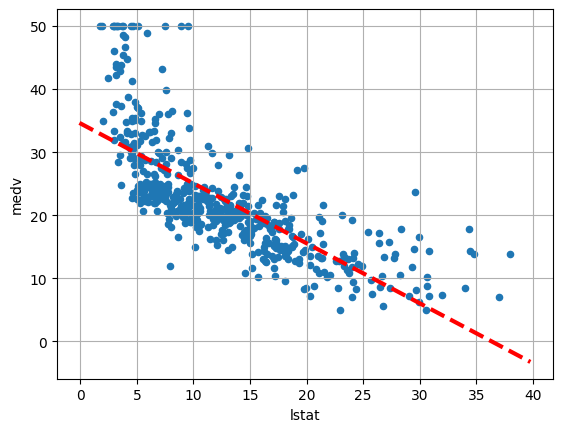

In [49]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax,
       results.params[0],
       results.params[1],
       'r--',
       linewidth=3)
ax.grid(True)


Thus, the final call to `ax.plot()` is `ax.plot(xlim, ylim, 'r--', linewidth=3)`.
We have used the argument `'r--'` to produce a red dashed line, and added
an argument to make it of width 3.
There is some evidence for non-linearity in the relationship between  `lstat`  and  `medv`. We will explore this issue later in this lab.

As mentioned above, there is an existing function to add a line to a plot --- `ax.axline()` --- but knowing how to write such functions empowers us to create more expressive displays.



Next we examine some diagnostic plots, several of which were discussed
in Section 3.3.3.
We can find the fitted values and residuals
of the fit as attributes of the `results` object.
Various influence measures describing the regression model
are computed with the `get_influence()` method.
As we will not use the `fig` component returned
as the first value from `subplots()`, we simply
capture the second returned value in `ax` below.

## Residual plots

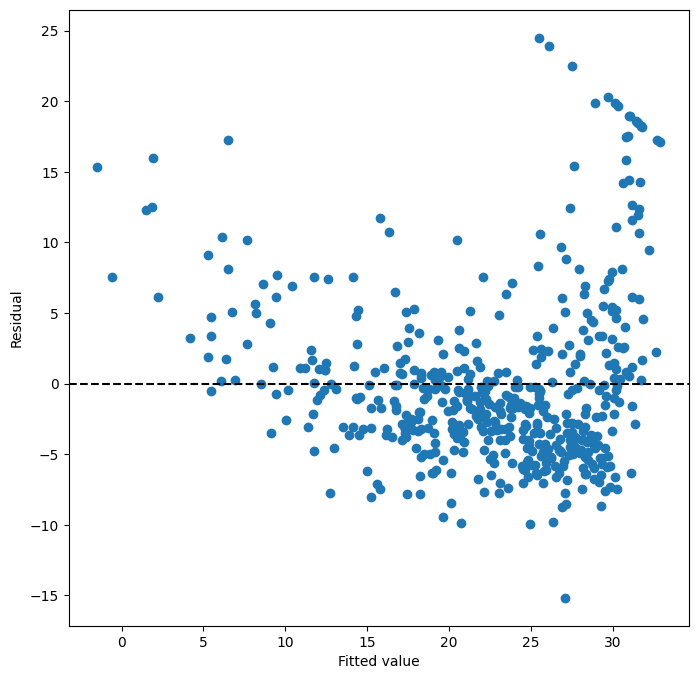

In [50]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');


 We add a horizontal line at 0 for reference using the
 `ax.axhline()`   method, indicating
it should be black (`c='k'`) and have a dashed linestyle (`ls='--'`).


In this case a pattern is visible, and therefore we may suspect alinearity: The quality of the fit is not the same when predictor values reach a certain level.

### Leverage
On the basis of the residual plot, there is some evidence of non-linearity.
Leverage statistics can be computed for any number of predictors using the
`hat_matrix_diag` attribute of the value returned by the
`get_influence()`  method.

We know that high-leverage pairs are the ones that dominate the regression line, so if we calculate each possible value of $h_i$, defined below, we are actually calculating the distance from a sample to the mean as compared with other samples. **If $h_i$ is high, leverage is high**.
$$
h_i = \frac{1}{n} + \frac{(x_i-\bar{x})^2}{\sum_{i=1}^{n}(x_i-\bar{x})^2}
$$

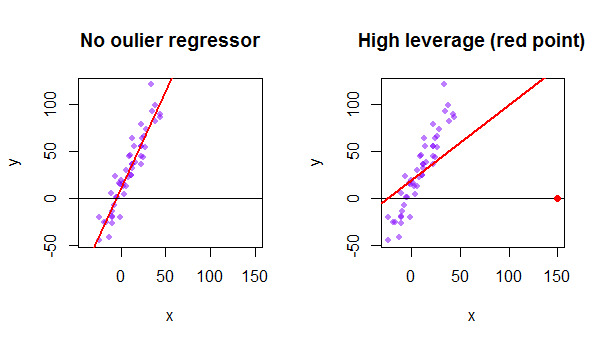

374

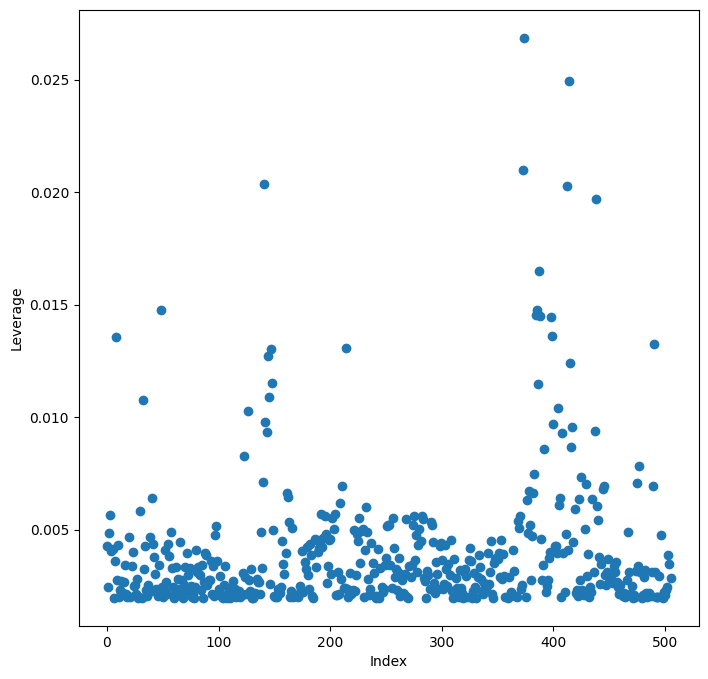

In [56]:
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

 The `np.argmax()`  function identifies the index of the largest element of an array, optionally computed over an axis of the array.
In this case, we maximized over the entire array
to determine which observation has the largest leverage statistic.

## Multiple Linear Regression
In order to fit a multiple linear regression model using least squares, we again use
the `ModelSpec()`  transform to construct the required
model matrix and response. The arguments
to `ModelSpec()` can be quite general, but in this case
a list of column names suffice. We consider a fit here with
the two variables `lstat` and `age`.

In [57]:
# The predictors are transformed in order for them to have the correct shape.
X = MS(['lstat', 'age']).fit_transform(Boston)
# And after transforming, we must apply a model. We decide to use a linear model.
model1 = sm.OLS(y, X)
# We fit it
results1 = model1.fit()
# And we get the results.
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


Notice how we have compacted the first line into a succinct expression describing the construction of `X`.

The  `Boston`   data set contains 12 variables, and so it would be cumbersome
to have to type all of these in order to perform a regression using all of the predictors.
Instead, we can use the following short-hand:\definelongblankMR{columns.drop()}{columns.slashslashdrop()}

In [58]:
terms = Boston.columns.drop('medv')
terms


Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

We can now fit the model with all the variables in `terms` using
the same model matrix builder.

In [59]:
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)


,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


What if we would like to perform a regression using all of the variables but one?  For
example, in the above regression output,   `age`  has a high $p$-value.
So we may wish to run a regression excluding this predictor.
The following syntax results in a regression using all predictors except  `age`.

In [28]:
minus_age = Boston.columns.drop(['medv', 'age']) 
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())


,coef,std err,t,P>|t|
intercept,41.5251,4.920,8.441,0.000
crim,-0.1214,0.033,-3.683,0.000
zn,0.0465,0.014,3.379,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8528,0.868,3.287,0.001
nox,-18.4851,3.714,-4.978,0.000
rm,3.6811,0.411,8.951,0.000
dis,-1.5068,0.193,-7.825,0.000
rad,0.2879,0.067,4.322,0.000
tax,-0.0127,0.004,-3.333,0.001


## Multivariate Goodness of Fit
We can access the individual components of `results` by name
(`dir(results)` shows us what is available). Hence
`results.rsquared` gives us the $R^2$,
and
`np.sqrt(results.scale)` gives us the RSE.

**Variance inflation factors** (section 3.3.3) are sometimes useful
to assess the effect of collinearity in the model matrix of a regression model.
We will compute the VIFs in our multiple regression fit, and use the opportunity to introduce the idea of *list comprehension*.

### List Comprehension
Often we encounter a sequence of objects which we would like to transform
for some other task. Below, we compute the VIF for each
feature in our `X` matrix and produce a data frame
whose index agrees with the columns of `X`.
The notion of list comprehension can often make such
a task easier.

List comprehensions are simple and powerful ways to form
lists of `Python` objects. The language also supports
dictionary and *generator* comprehension, though these are
beyond our scope here. Let's look at an example. We compute the VIF for each of the variables
in the model matrix `X`, using the function `variance_inflation_factor()`.

If the VIF is close to 1, colinearity is absent.

In [61]:
# VIF is calculated for each predictor:
# VIF (ALL PREDICTORS ALL VALUES, THE PREDICTOR I WANT TO CALCULATE)
vals = [VIF(X, i)
        for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals},
                   index=X.columns[1:])
vif


,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


In [60]:
X.shape[1]

13

The function `VIF()` takes two arguments: a dataframe or array,
and a variable column index. In the code above we call `VIF()` on the fly for all columns in `X`.  
We have excluded column 0 above (the intercept), which is not of interest. In this case the VIFs are not that exciting.

The object `vals` above could have been constructed with the following for loop:

In [62]:
vals = []
for i in range(1, X.values.shape[1]):
    vals.append(VIF(X.values, i))


List comprehension allows us to perform such repetitive operations in a more straightforward way.
## Interaction Terms
It is easy to include interaction terms in a linear model using `ModelSpec()`.
Including a tuple `("lstat","age")` tells the model
matrix builder to include an interaction term between
 `lstat`  and  `age`.

In [63]:
X = MS(['lstat',
        'age',
        ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())


,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


## Non-linear Transformations of the Predictors
The model matrix builder can include terms beyond
just column names and interactions. For instance,
the `poly()` function supplied in `ISLP` specifies that
columns representing polynomial functions
of its first argument are added to the model matrix.

In [65]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)


,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


The effectively zero *p*-value associated with the quadratic term
(i.e. the third row above) suggests that it leads to an improved model.

By default, `poly()` creates a basis matrix for inclusion in the
model matrix whose
columns are *orthogonal polynomials*, which are designed for stable
least squares computations. {Actually, `poly()` is a  wrapper for the workhorse and standalone  function `Poly()` that does the  work in building the model matrix.}
Alternatively, had we included an argument
`raw=True` in the above call to `poly()`, the basis matrix would consist simply of
`lstat` and `lstat**2`. Since either of these bases
represent quadratic polynomials, the fitted values  would not
change in this case, just the polynomial coefficients.  Also by default, the columns
created by `poly()` do not include an intercept column as
that is automatically added by `MS()`.

We use the `anova_lm()` function to further quantify the extent to which the quadratic fit is
superior to the linear fit.

In [66]:
anova_lm(results1, results3)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Here `results1` represents the linear submodel containing
predictors `lstat` and `age`,
while `results3` corresponds to the larger model above  with a quadratic
term in `lstat`.
The `anova_lm()` function performs a hypothesis test
comparing the two models. The null hypothesis is that the quadratic
term in the bigger model is not needed, and the alternative hypothesis is that the
bigger model is superior. Here the *F*-statistic is 177.28 and
the associated *p*-value is zero.
In this case the *F*-statistic is the square of the
*t*-statistic for the quadratic term in the linear model summary
for `results3` --- a consequence of the fact that these nested
models differ by one degree of freedom.
This provides very clear evidence that the quadratic polynomial in
`lstat` improves the linear model.
This is not surprising, since earlier we saw evidence for non-linearity in the relationship between `medv`
and  `lstat`.

The function `anova_lm()` can take more than two nested models
as input, in which case it compares every successive pair of models.
That also explains why their are `NaN`s in the first row above, since
there is no previous model with which to compare the first.


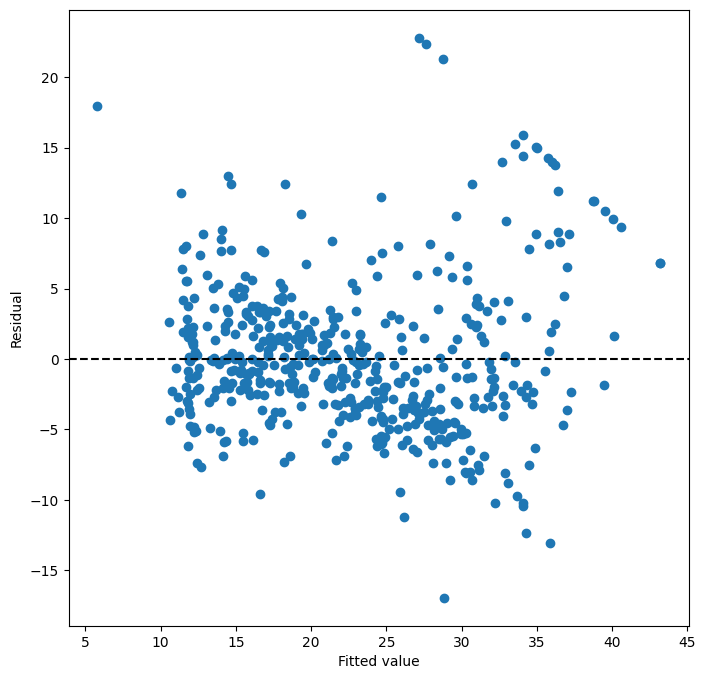

In [67]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results3.fittedvalues, results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')


We see that when the quadratic term is included in the model,
there is little discernible pattern in the residuals.
In order to create a cubic or higher-degree polynomial fit, we can simply change the degree argument
to `poly()`.


## Qualitative Predictors
Here we use the  `Carseats`  data, which is included in the
`ISLP` package. We will  attempt to predict `Sales`
(child car seat sales) in 400 locations based on a number of
predictors.

In [68]:
Carseats = load_data('Carseats')
Carseats.columns


Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

The `Carseats`  
 data includes qualitative predictors such as
 `ShelveLoc`, an indicator of the quality of the shelving
 location --- that is,
the  space within a store in which the car seat is displayed. The predictor
 `ShelveLoc`  takes on three possible values, `Bad`, `Medium`, and `Good`.
Given a qualitative variable such as  `ShelveLoc`, `ModelSpec()` generates dummy
variables automatically.
These variables are often referred to as a *one-hot encoding* of the categorical
feature. Their columns sum to one, so to avoid collinearity with an intercept, the first column is dropped. Below we see
the column `ShelveLoc[Bad]` has been dropped, since `Bad` is the first level of `ShelveLoc`.
Below we fit a multiple regression model that includes some interaction terms.

In [69]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
# We add interaction terms!
final = allvars + [('Income', 'Advertising'),
                   ('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())


,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


In the first line above, we made `allvars` a list, so that we
could add the interaction terms two lines down. 
Our model-matrix builder has created a `ShelveLoc[Good]`
dummy variable that takes on a value of 1 if the
shelving location is good, and 0 otherwise. It has also created a `ShelveLoc[Medium]`
dummy variable that equals 1 if the shelving location is medium, and 0 otherwise.
A bad shelving location corresponds to a zero for each of the two dummy variables.
The fact that the coefficient for `ShelveLoc[Good]` in the regression output is
positive indicates that a good shelving location is associated with high sales (relative to a bad location).
And `ShelveLoc[Medium]` has a smaller positive coefficient,
indicating that a medium shelving location leads to higher sales than a bad
shelving location, but lower sales than a good shelving location.

